In [2]:
## Está funcionando en los entonrnos BERT_test y AnomalyBERT_env.

import	json
import	numpy                			as		np
import	torch

import	matplotlib.pyplot    			as		plt
%matplotlib inline

import	os

os.chdir( './AnomalyBERT' )

import	AnomalyBERT.utils.config		as		config
from	AnomalyBERT.estimate			import	estimate
from	AnomalyBERT.compute_metrics		import	f1_score
import	train

os.chdir( os.path.dirname( os.getcwd() ) )



In [2]:
print( torch.__version__ )
print( torch.cuda.is_available() )

2.2.0+cu118
True


In [ ]:
# Código de partida para la creación de la función de carga de datos.

normal_data = pd.read_csv(os.path.join(base_dir, 'WADI/WADI.A2_19 Nov 2019/WADI_14days_new.csv'))
normal_data = normal_data.dropna(axis='columns', how='all').dropna()
normal_data = normal_data.iloc[:, 3:].to_numpy()
normal_data = MinMaxScaler().fit_transform(normal_data).clip(0, 1)
np.save(os.path.join(output_folder, dataset + "_train.npy"), normal_data)

abnormal_data = pd.read_csv(os.path.join(base_dir, 'WADI/WADI.A2_19 Nov 2019/WADI_attackdataLABLE.csv'), header=1)
abnormal_data = abnormal_data.dropna(axis='columns', how='all').dropna()
abnormal_label = abnormal_data.iloc[:, -1] == -1
abnormal_label = abnormal_label.to_numpy().astype(int)

abnormal_data = abnormal_data.iloc[:, 3:-1].to_numpy()
abnormal_data = MinMaxScaler().fit_transform(abnormal_data).clip(0, 1)
np.save(os.path.join(output_folder, dataset + "_test.npy"), abnormal_data)
np.save(os.path.join(output_folder, dataset + "_test_label.npy"), abnormal_label)

In [3]:
class hyperparameters :
    def __init__    ( self
        			, gpu_id                    = 0         # default = 0       , type = float
                    , lr                        = 1e-4      # default = 1e-4    , type = float
                    , max_steps                 = 150000    # default = 150000  , type = int    , help = 'maximum_training_steps'
                    , summary_steps             = 500       # default = 500     , type = int    , help = 'steps for summarizing and saving of training log'
                    , checkpoint                = None      # default = None    , type = str    , help = 'load checkpoint file'
                    , initial_iter              = 0         # default = 0       , type = int    , help = 'initial iteration for training'
#
                    , dataset                   = 'SMAP'    # default = 'SMAP'  , type = str    , help = 'SMAP/MSL/SMD/SWaT/WADI'
                    , replacing_data            = None      # default = None    , type = str    , help = 'external data for soft replacement; None(default)/SMAP/MSL/SMD/SWaT/WADI'

                    , batch_size                = 16        # default = 16      , type = int
                    , n_features                = 512       # default = 512     , type = int    , help = 'number of features for a window'
                    , patch_size                = 4         # default = 4       , type = int    , help = 'number of data points in a patch'
                    , d_embed                   = 512       # default = 512     , type = int    , help = 'embedding dimension of feature'
                    , n_layer                   = 6         # default = 6       , type = int    , help = 'number of transformer layers'
                    , dropout                   = 0.1       # default = 0.1     , type = float
                    , replacing_rate_max        = 0.15      # default = 0.15    , type = float  , help = 'maximum ratio of replacing interval length to window size'
#
                    , soft_replacing            = 0.5       # default = 0.5     , type = float  , help = 'probability for soft replacement'
                    , uniform_replacing         = 0.15      # default = 0.15    , type = float  , help = 'probability for uniform replacement'
                    , peak_noising              = 0.15      # default = 0.15    , type = float  , help = 'probability for peak noise'
                    , length_adjusting          = 0.0       # default = 0.0     , type = float  , help = 'probability for length adjustment'
                    , white_noising             = 0.0       # default = 0.0     , type = float  , help = 'probability for white noise (deprecated)'

                    , flip_replacing_interval   = 'all'     # default = 'all'   , type = str    , help = 'allowance for random flipping in soft replacement; vertical/horizontal/all/none'
                    , replacing_weight          = 0.7       # default = 0.7     , type = float  , help = 'weight for external interval in soft replacement'
    
                    , window_sliding            = 16        # default = 16      , type = int    , help = 'sliding steps of windows for validation'
                    , data_division             = None      # default = None    , type = str    , help = 'data division for validation; None(default)/channel/class/total'
#
                    , loss                      = 'bce'     # default = 'bce'   , type = str    , help = 'loss type'
                    , grad_clip_norm            = 1.0       # default = 1.0     , type = float
#
                    , default_options           = None      # default options for datasets; None(default)/SMAP/MSL/SMD/SWaT/WADI
                    ):
        self.gpu_id						= gpu_id
        self.lr							= lr
        self.max_steps					= max_steps
        self.summary_steps				= summary_steps
        self.checkpoint					= checkpoint
        self.initial_iter				= initial_iter

        self.dataset					= dataset
        self.replacing_data				= replacing_data

        self.batch_size					= batch_size
        self.n_features					= n_features
        self.patch_size					= patch_size
        self.d_embed					= d_embed
        self.n_layer					= n_layer
        self.dropout					= dropout
        self.replacing_rate_max			= replacing_rate_max

        self.soft_replacing				= soft_replacing
        self.uniform_replacing			= uniform_replacing
        self.peak_noising				= peak_noising
        self.length_adjusting			= length_adjusting
        self.white_noising				= white_noising

        self.flip_replacing_interval	= flip_replacing_interval
        self.replacing_weight			= replacing_weight

        self.window_sliding				= window_sliding
        self.data_division				= data_division

        self.loss						= loss
        self.grad_clip_norm				= grad_clip_norm

        self.default_options			= default_options

In [4]:
options = hyperparameters()
import utils.config as config

train_data = np.load(config.TRAIN_DATASET[options.dataset]).copy().astype(np.float32)

print(config.TRAIN_DATASET)
print(config.TRAIN_DATASET[options.dataset])
display(train_data)
print(train_data.shape)

{'SMAP': '/Users/zoiyy/OneDrive/Documentos/DataSets/TFM/AnomalyBERT/processed\\SMAP_train.npy', 'MSL': '/Users/zoiyy/OneDrive/Documentos/DataSets/TFM/AnomalyBERT/processed\\MSL_train.npy', 'SMD': '/Users/zoiyy/OneDrive/Documentos/DataSets/TFM/AnomalyBERT/processed\\SMD_train.npy', 'SWaT': '/Users/zoiyy/OneDrive/Documentos/DataSets/TFM/AnomalyBERT/processed\\SWaT_train.npy', 'WADI': '/Users/zoiyy/OneDrive/Documentos/DataSets/TFM/AnomalyBERT/processed\\WADI_train.npy', 'SMD0': '/Users/zoiyy/OneDrive/Documentos/DataSets/TFM/AnomalyBERT/processed\\SMD0_train.npy', 'SMD1': '/Users/zoiyy/OneDrive/Documentos/DataSets/TFM/AnomalyBERT/processed\\SMD1_train.npy', 'SMD2': '/Users/zoiyy/OneDrive/Documentos/DataSets/TFM/AnomalyBERT/processed\\SMD2_train.npy', 'SMD3': '/Users/zoiyy/OneDrive/Documentos/DataSets/TFM/AnomalyBERT/processed\\SMD3_train.npy', 'SMD4': '/Users/zoiyy/OneDrive/Documentos/DataSets/TFM/AnomalyBERT/processed\\SMD4_train.npy', 'SMD5': '/Users/zoiyy/OneDrive/Documentos/DataSets/TF

array([[0.9995    , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.9995    , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.9995    , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.99387795, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.9920895 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.9920895 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

(135183, 25)


In [8]:
import os

base_dir = r'C:\Users\zoiyy\OneDrive\Documentos\DataSets\TFM\AnomalyBERT'
dataset_folder = os.path.join(base_dir, 'telemanom/data')
category = 'train'
filename = 'P-1'
temp = np.load(os.path.join(dataset_folder, category, filename + '.npy'))

print(dataset_folder)
print(os.path.join(dataset_folder, category, filename + '.npy'))
display(temp)
print(temp.shape)

C:\Users\zoiyy\OneDrive\Documentos\DataSets\TFM\AnomalyBERT\telemanom/data
C:\Users\zoiyy\OneDrive\Documentos\DataSets\TFM\AnomalyBERT\telemanom/data\train\P-1.npy


array([[-0.52315476,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.68885677,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.55499272,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.72575974,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.68958026,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.70984087,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

(2872, 25)


In [6]:
train.main(options)

c:\Users\zoiyy\OneDrive\Documentos\Repositorios GIT\TFM\AnomalyBERT\compute_metrics.py:102: RuntimeWarning: invalid value encountered in scalar divide
  f1_score = 2*precision*recall/(precision+recall)


iteration: 0 | loss: 1.1174218655 | train accuracy: 0.6382446289
anomaly rate: 0.236 | precision: 0.13366 | recall: 0.24662 | F1-score: 0.17336



KeyboardInterrupt: 

In [3]:
device  = torch.device( 'cuda' )
model   = torch.load( 'logs/best_checkpoints/SWaT_parameters.pt' , map_location = device )
model.eval()

AnomalyTransformer(
  (linear_embedding): Linear(in_features=700, out_features=512, bias=True)
  (transformer_encoder): TransformerEncoder(
    (encoder_layers): ModuleList(
      (0-5): 6 x EncoderLayer(
        (attention_layer): MultiHeadAttentionLayer(
          (word_fc_layers): ModuleList(
            (0-2): 3 x Linear(in_features=512, out_features=512, bias=True)
          )
          (output_fc_layer): Linear(in_features=512, out_features=512, bias=True)
        )
        (feed_forward_layer): PositionWiseFeedForwardLayer(
          (first_fc_layer): Linear(in_features=512, out_features=2048, bias=True)
          (second_fc_layer): Linear(in_features=2048, out_features=512, bias=True)
          (activation_layer): GELU()
          (dropout_layer): Dropout(p=0.1, inplace=False)
        )
        (norm_layers): ModuleList(
          (0-1): 2 x LayerNorm((512,), eps=1e-06, elementwise_affine=True)
        )
        (dropout_layer): Dropout(p=0.1, inplace=False)
      )
    )
  )
 

In [4]:
# Load test dataset.
dataset = 'SWaT'  # or any dataset in SWaT/SMAP/MSL/SMD/WADI
test_data = np.load(config.TEST_DATASET[dataset])
test_label = np.load(config.TEST_LABEL[dataset])

# Data divisions.
test_divisions = config.DEFAULT_DIVISION[dataset]
if test_divisions == 'total':
        test_divisions = [[0, len(test_data)]]
else:
    with open(config.DATA_DIVISION[dataset][test_divisions], 'r') as f:
        test_divisions = json.load(f)
    if isinstance(test_divisions, dict):
        test_divisions = test_divisions.values()

# Ignore the specific columns.
if dataset in config.IGNORED_COLUMNS.keys():
    ignored_column = np.array(config.IGNORED_COLUMNS[dataset])
    remaining_column = [col for col in range(len(test_data[0])) if col not in ignored_column]
    test_data = test_data[:, remaining_column]

In [5]:
# Estimate anomaly scores.
anomaly_scores = estimate(test_data, model, torch.nn.Sigmoid().to(device), 1, 64, 16, test_divisions, 5000, device)
anomaly_scores = anomaly_scores.cpu().numpy()

5056 windows are computed.
10048 windows are computed.
15040 windows are computed.
20032 windows are computed.
25024 windows are computed.


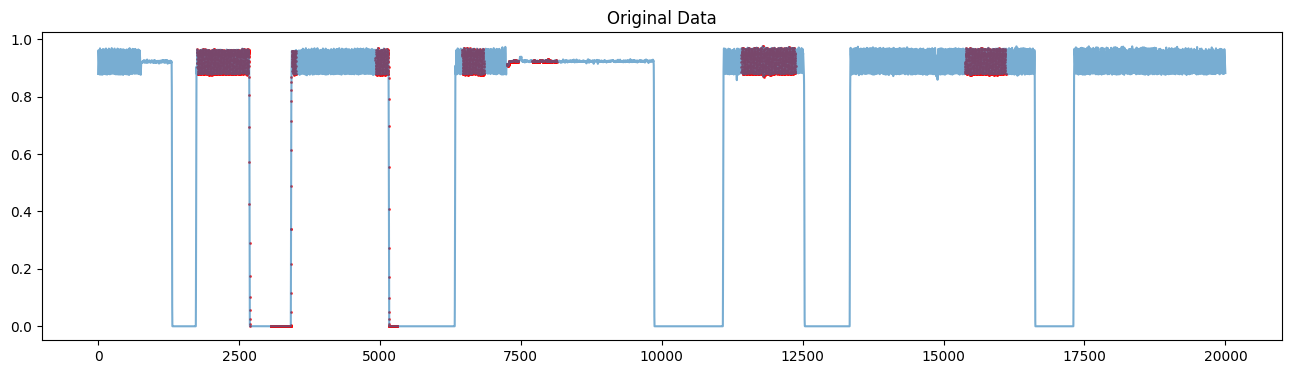

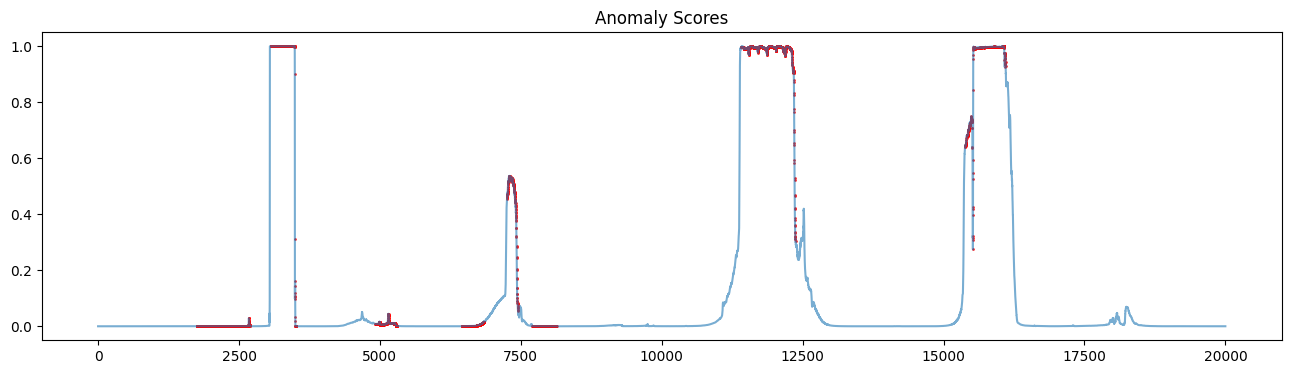

In [6]:
# Plot data and anomaly scores.
index = (0, 20000)  # interval for time steps
data_col_index = 0  # index of data column

label = test_label[index[0]:index[1]].astype(bool)

plt.figure(figsize=(16, 4))
plt.plot(test_data[index[0]:index[1], data_col_index], alpha=0.6)
plt.scatter(np.arange(index[1]-index[0])[label], test_data[index[0]:index[1]][label, data_col_index],
            c='r', s=1, alpha=0.8)
plt.title('Original Data')
plt.show()

plt.figure(figsize=(16, 4))
plt.plot(anomaly_scores[index[0]:index[1], 0], alpha=0.6)
plt.scatter(np.arange(index[1]-index[0])[label], anomaly_scores[index[0]:index[1]][label, 0],
            c='r', s=1, alpha=0.8)
plt.title('Anomaly Scores')
plt.show()

In [7]:
# Compute precisions, recalls, F1-scores of the result.
# Standard metrics
best_eval = (0, 0, 0)
best_rate = 0
for rate in np.arange(0.001, 0.301, 0.001):
    evaluation = f1_score(test_label, anomaly_scores[:, 0], rate, False)
    if evaluation[2] > best_eval[2]:
        best_eval = evaluation
        best_rate = rate
print('Best F1-score without point adjustment')
print(f'anomaly rate: {best_rate:.3f} | precision: {best_eval[0]:.5f} | recall: {best_eval[1]:.5f} | F1-score: {best_eval[2]:.5f}\n')

# Metrics after point adjustment
best_eval = (0, 0, 0)
best_rate = 0
for rate in np.arange(0.001, 0.301, 0.001):
    evaluation = f1_score(test_label, anomaly_scores[:, 0], rate, True)
    if evaluation[2] > best_eval[2]:
        best_eval = evaluation
        best_rate = rate
print('Best F1-score with point adjustment')
print(f'anomaly rate: {best_rate:.3f} | precision: {best_eval[0]:.5f} | recall: {best_eval[1]:.5f} | F1-score: {best_eval[2]:.5f}\n')

Best F1-score without point adjustment
anomaly rate: 0.097 | precision: 0.96130 | recall: 0.76861 | F1-score: 0.85423

Best F1-score with point adjustment
anomaly rate: 0.040 | precision: 0.97682 | recall: 0.87762 | F1-score: 0.92456



In [8]:
import	Adapted_utils.Adapted_config	as		config2

In [13]:
config2.set_directory()

print(config2.DATASET_DIR)
print(config2.TEST_DATASET)

/Users/zoiyy/OneDrive/Documentos/DataSets/TFM/AnomalyBERT/processed
{'SMAP': '/Users/zoiyy/OneDrive/Documentos/DataSets/TFM/AnomalyBERT/processed\\SMAP_test.npy', 'MSL': '/Users/zoiyy/OneDrive/Documentos/DataSets/TFM/AnomalyBERT/processed\\MSL_test.npy', 'SMD': '/Users/zoiyy/OneDrive/Documentos/DataSets/TFM/AnomalyBERT/processed\\SMD_test.npy', 'SWaT': '/Users/zoiyy/OneDrive/Documentos/DataSets/TFM/AnomalyBERT/processed\\SWaT_test.npy', 'WADI': '/Users/zoiyy/OneDrive/Documentos/DataSets/TFM/AnomalyBERT/processed\\WADI_test.npy', 'SMD0': '/Users/zoiyy/OneDrive/Documentos/DataSets/TFM/AnomalyBERT/processed\\SMD0_test.npy', 'SMD1': '/Users/zoiyy/OneDrive/Documentos/DataSets/TFM/AnomalyBERT/processed\\SMD1_test.npy', 'SMD2': '/Users/zoiyy/OneDrive/Documentos/DataSets/TFM/AnomalyBERT/processed\\SMD2_test.npy', 'SMD3': '/Users/zoiyy/OneDrive/Documentos/DataSets/TFM/AnomalyBERT/processed\\SMD3_test.npy', 'SMD4': '/Users/zoiyy/OneDrive/Documentos/DataSets/TFM/AnomalyBERT/processed\\SMD4_test.n

In [11]:
ruta = 'D:\Series'

In [14]:
config2.set_directory( ruta )

print(config2.DATASET_DIR)
print(config2.TEST_DATASET)

D:\Series
{'SMAP': 'D:\\Series\\SMAP_test.npy', 'MSL': 'D:\\Series\\MSL_test.npy', 'SMD': 'D:\\Series\\SMD_test.npy', 'SWaT': 'D:\\Series\\SWaT_test.npy', 'WADI': 'D:\\Series\\WADI_test.npy', 'SMD0': 'D:\\Series\\SMD0_test.npy', 'SMD1': 'D:\\Series\\SMD1_test.npy', 'SMD2': 'D:\\Series\\SMD2_test.npy', 'SMD3': 'D:\\Series\\SMD3_test.npy', 'SMD4': 'D:\\Series\\SMD4_test.npy', 'SMD5': 'D:\\Series\\SMD5_test.npy', 'SMD6': 'D:\\Series\\SMD6_test.npy', 'SMD7': 'D:\\Series\\SMD7_test.npy', 'SMD8': 'D:\\Series\\SMD8_test.npy', 'SMD9': 'D:\\Series\\SMD9_test.npy', 'SMD10': 'D:\\Series\\SMD10_test.npy', 'SMD11': 'D:\\Series\\SMD11_test.npy', 'SMD12': 'D:\\Series\\SMD12_test.npy', 'SMD13': 'D:\\Series\\SMD13_test.npy', 'SMD14': 'D:\\Series\\SMD14_test.npy', 'SMD15': 'D:\\Series\\SMD15_test.npy', 'SMD16': 'D:\\Series\\SMD16_test.npy', 'SMD17': 'D:\\Series\\SMD17_test.npy', 'SMD18': 'D:\\Series\\SMD18_test.npy', 'SMD19': 'D:\\Series\\SMD19_test.npy', 'SMD20': 'D:\\Series\\SMD20_test.npy', 'SMD21': 

In [4]:
import os

os.chdir( './AnomalyBERT' )
path									= os.getcwd()
import	AnomalyBERT.utils.config	as		config
from	AnomalyBERT.estimate		import	estimate
from	AnomalyBERT.compute_metrics	import	f1_score
os.chdir( os.path.dirname( path ) )

In [7]:
print(config.DATASET_DIR)
print(config.TEST_DATASET)

/Users/zoiyy/OneDrive/Documentos/DataSets/TFM/AnomalyBERT/processed
{'SMAP': '/Users/zoiyy/OneDrive/Documentos/DataSets/TFM/AnomalyBERT/processed\\SMAP_test.npy', 'MSL': '/Users/zoiyy/OneDrive/Documentos/DataSets/TFM/AnomalyBERT/processed\\MSL_test.npy', 'SMD': '/Users/zoiyy/OneDrive/Documentos/DataSets/TFM/AnomalyBERT/processed\\SMD_test.npy', 'SWaT': '/Users/zoiyy/OneDrive/Documentos/DataSets/TFM/AnomalyBERT/processed\\SWaT_test.npy', 'WADI': '/Users/zoiyy/OneDrive/Documentos/DataSets/TFM/AnomalyBERT/processed\\WADI_test.npy', 'SMD0': '/Users/zoiyy/OneDrive/Documentos/DataSets/TFM/AnomalyBERT/processed\\SMD0_test.npy', 'SMD1': '/Users/zoiyy/OneDrive/Documentos/DataSets/TFM/AnomalyBERT/processed\\SMD1_test.npy', 'SMD2': '/Users/zoiyy/OneDrive/Documentos/DataSets/TFM/AnomalyBERT/processed\\SMD2_test.npy', 'SMD3': '/Users/zoiyy/OneDrive/Documentos/DataSets/TFM/AnomalyBERT/processed\\SMD3_test.npy', 'SMD4': '/Users/zoiyy/OneDrive/Documentos/DataSets/TFM/AnomalyBERT/processed\\SMD4_test.n